In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from IPython.display import HTML, Latex, Markdown, Pretty

from windIO.Plant import WTLayout
from fusedwake.WindFarm import WindFarm
from fusedwake.Plotting import circles

from fusedwake.gcl import GCL
import fusedwake.gcl.fortran as fgcl
import fusedwake.gcl.python as pygcl

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#filename = 'middelgrunden.yml'
#filename = 'lillgrund.yml'
#filename = 'hornsrev.yml'

#filename = 'test_WF.yml'
#filename = 'test_WF_4.yml'
filename = 'test_WF_4Turbines.yml'

#wtl = WTLayout(filename)
wf = WindFarm(yml=filename)

In [3]:
# Fixed parameters
a1 = 0.435449861
a2 = 0.797853685
a3 = -0.124807893
a4 = 0.136821858
b1 = 15.6298
b2 = 1.0

# Variables
D = 80.0
CT = 0.98
TI = 0.10


print np.allclose(fgcl.get_r96(D, CT, TI, a1, a2, a3, a4, b1, b2),
                  pygcl.get_r96(D, CT, TI, pars=[a1, a2, a3, a4, b1, b2]))

R = D/2.
x=4.*D
r=0.*R

print [np.allclose(fgcl.get_rw(x, D, CT, TI, a1, a2, a3, a4, b1, b2)[i],
                  pygcl.get_Rw(x, R, TI, CT, pars=[a1, a2, a3, a4, b1, b2])[i]) for i in range(3)]

print np.allclose(fgcl.get_du(x,r,D,CT, TI, a1, a2, a3, a4, b1, b2),
                  pygcl.get_dU(x,r,R, CT, TI, pars=[a1, a2, a3, a4, b1, b2]))

R = D/2.
x=D*np.linspace(0.,10.,100)
r=0.*R*np.ones_like(x)

print [np.allclose(fgcl.get_rw(x, D, CT, TI, a1, a2, a3, a4, b1, b2)[i],
                  pygcl.get_Rw(x, R, TI, CT, pars=[a1, a2, a3, a4, b1, b2])[i]) for i in range(3)]

print np.allclose(fgcl.get_du(x,r,D,CT, TI, a1, a2, a3, a4, b1, b2),
                  pygcl.get_dU(x,r,R, CT, TI, pars=[a1, a2, a3, a4, b1, b2]))


R = D/2.
x=D*np.linspace(0.,10.,100)
r=D*np.linspace(0.,2.,100) 

print np.allclose(fgcl.get_du(x,r,D,CT, TI, a1, a2, a3, a4, b1, b2),
                  pygcl.get_dU(x,r,R, CT, TI, pars=[a1, a2, a3, a4, b1, b2]))


dx = 7.*D
dy = 6.*D
dz = -2.*D
# Wake operating turbine
RT = 2.*R
DT = 2.*RT

print np.allclose(fgcl.get_dueq(dx,dy,dz,DT,D,CT,TI,a1,a2,a3,a4,b1,b2),
                  pygcl.get_dUeq(dx,dy,dz,RT,R,CT,TI,pars=[a1, a2, a3, a4, b1, b2]))


dx = np.array([6.,10.,15.])*D
dy = np.array([1.,-5.,0.])*D
dz = np.array([-2,2.,1.])*D

# Wake operating turbines
Rop = np.array([1.,2.,.5])*D 
Dop = 2.*Rop

print np.allclose(fgcl.get_dueq(dx,dy,dz,Dop,D,CT,TI,a1,a2,a3,a4,b1,b2),
                  pygcl.get_dUeq(dx,dy,dz,Rop,R,CT,TI,pars=[a1, a2, a3, a4, b1, b2]))


True
[True, True, True]
True
[True, True, True]
True
True
True
True


In [4]:
gcl = GCL(WF=wf)

In [5]:
# Inputs
WS=10.0*np.ones([wf.nWT])
WD=271.*np.ones([wf.nWT])#np.random.normal(270.,30.)*np.ones([wf.nWT])#
TI=0.1*np.ones([wf.nWT])

print np.mean(WD)

271.0


(-50, 1000)

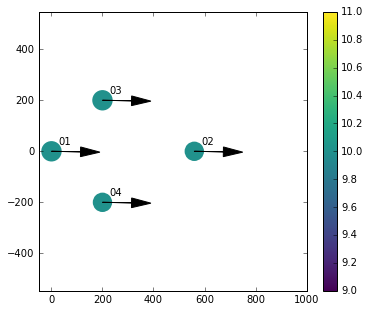

In [6]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
circles(x=wf.xyz[0,:],
        y=wf.xyz[1,:],
        s=np.array(wf.R),
        c=WS, 
        cmap=plt.cm.viridis,lw=0,
        )
plt.colorbar()
for i in range(wf.nWT):
    ax.annotate(str(wf.__getattr__('name')[i][-2:]).zfill(2),wf.xyz[[0,1],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=0.5*wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=0.5*wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=2*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
ax.axis('equal')
ax.set_xlim([-50, 1000])
#ax.set_ylim([-400, 400])




In [7]:
gcl = GCL(WF=wf,WS=WS, WD=WD, TI=TI)
# Run the models
out_fort_gclm_s=gcl(version='fort_gclm')
#print gcl._get_kwargs(version='fort_gclm'),'\n'
print gcl.version, ':', out_fort_gclm_s.p_wt.sum(),'\n'

# Run the models
out_py_gcl_v0=gcl(version='py_gcl_v0')
#print gcl._get_kwargs(version='py_gcl_v0'),'\n'
print gcl.version, ':', out_py_gcl_v0.p_wt.sum(),'\n'

print np.allclose(out_fort_gclm_s.p_wt,out_py_gcl_v0.p_wt)
print np.allclose(out_fort_gclm_s.u_wt,out_py_gcl_v0.u_wt),'\n'

# Run the models
out_py_gcl_v1=gcl(version='py_gcl_v1')
#print gcl._get_kwargs(version='py_gcl_v1'),'\n'
print gcl.version, ':', out_py_gcl_v1.p_wt.sum(),'\n'
print np.allclose(out_fort_gclm_s.p_wt,out_py_gcl_v1.p_wt)
print np.allclose(out_fort_gclm_s.u_wt,out_py_gcl_v1.u_wt),'\n'


fort_gclm : 4768476.6996 

py_gcl_v0 : 4768476.69851 

True
True 

py_gcl_v1 : 4768476.69851 

True
True 



(-100, 1000)

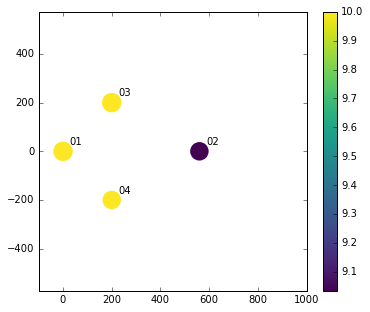

In [8]:
varout=out_py_gcl_v0.u_wt#p_wt/1e6
    
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
circles(x=wf.xyz[0,:],
        y=wf.xyz[1,:],
        s=np.array(wf.R),
        c=varout,
        cmap=plt.cm.viridis,lw=0,
        )
plt.colorbar()
for i in range(wf.nWT):
    ax.annotate(str(wf.__getattr__('name')[i][-2:]).zfill(2),wf.xyz[[0,1],i]+0.7*np.array([wf.R[i],wf.R[i]]))
ax.axis('equal')
ax.set_xlim([-100, 1000])
#ax.set_ylim([-500, 500])

In [9]:
# Inputs
WS=10.0*np.ones([wf.nWT])+np.random.normal(loc=0.0, scale=0.25, size=[wf.nWT])
WD=285*np.ones([wf.nWT])+np.random.normal(loc=0.0, scale=3., size=[wf.nWT])
TI=0.1*np.ones([wf.nWT])+np.random.normal(loc=0.0, scale=0.02, size=[wf.nWT])
version = 'py_gcl_v0' #'fort_gclm_s' # 

# Run the models
results=gcl(WS=WS, WD=WD, TI=TI, version=version)
results.p_wt.sum()

4837475.9881058317

(-50, 1000)

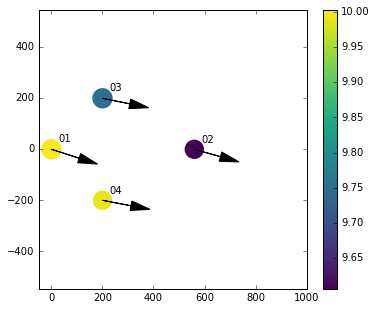

In [10]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
circles(x=wf.xyz[0,:],
        y=wf.xyz[1,:],
        s=np.array(wf.R),
        c=WS,
        cmap=plt.cm.viridis,lw=0,
        )
plt.colorbar()
for i in range(wf.nWT):
    ax.annotate(str(wf.__getattr__('name')[i][-2:]).zfill(2),wf.xyz[[0,1],i]+0.7*np.array([wf.R[i],wf.R[i]]))
    ax.arrow(x=wf.xyz[0,i],
          y=wf.xyz[1,i],
          dx=0.5*wf.R[1]*WS[i]*np.cos(np.deg2rad(270-WD[i])),
          dy=0.5*wf.R[1]*WS[i]*np.sin(np.deg2rad(270-WD[i])),
          head_length=2*wf.R[1],head_width=wf.R[1],
          length_includes_head=True,
          fc='k',ec='k',
         )
ax.axis('equal')
ax.set_xlim([-50, 1000])
#ax.set_ylim([-400, 400])


(-100, 1000)

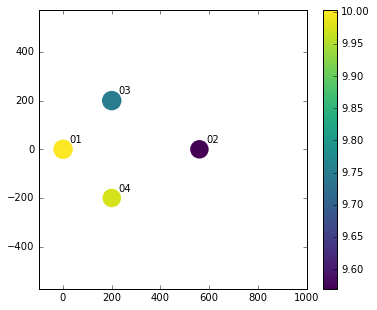

In [11]:
varout=results.u_wt#p_wt/1e6

fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
circles(x=wf.xyz[0,:],
        y=wf.xyz[1,:],
        s=np.array(wf.R),
        c=varout,
        cmap=plt.cm.viridis,lw=0,
        )
plt.colorbar()
for i in range(wf.nWT):
    ax.annotate(str(wf.__getattr__('name')[i][-2:]).zfill(2),wf.xyz[[0,1],i]+0.7*np.array([wf.R[i],wf.R[i]]))
ax.axis('equal')
ax.set_xlim([-100, 1000])
#ax.set_ylim([-500, 500])

In [12]:
WD = (np.arange(-50,50)+270.)#np.linspace(-50,50,200)+270
WS = 10.

In [13]:
P_rat_py_v0 = []
P_rat_py_v1 = []
P_rat_fgclm_rdn = []
for wd in WD:       
    #out = gcl(WF=wf, WS=WS*np.ones([wf.nWT]), WD=wd+np.random.normal(loc=0.0, scale=2, size=[wf.nWT]), 
    #          TI=0.1*np.ones([wf.nWT]), version='fort_gclm')
    #P_rat_fgclm_rdn = np.append(P_rat_fgclm_rdn,out.p_wt[1]/out.p_wt[0])
    
    out = gcl(WS=WS*np.ones([wf.nWT]), WD=wd*np.ones([wf.nWT]), TI=0.1*np.ones([wf.nWT]), version='py_gcl_v1')
    P_rat_py_v1 = np.append(P_rat_py_v1,out.p_wt[1]/out.p_wt[0])

    out = gcl(WF=wf, WS=WS*np.ones([wf.nWT]), WD=wd*np.ones([wf.nWT]), TI=0.1*np.ones([wf.nWT]), version='py_gcl_v0')
    P_rat_py_v0 = np.append(P_rat_py_v0,out.p_wt[1]/out.p_wt[0])

In [15]:
out = gcl(WF=wf, WS=WS*np.ones_like(WD), WD=WD, TI=0.1*np.ones_like(WD), version='fort_gcl')
P_rat_fgcl = out.p_wt[:,1]/out.p_wt[:,0]

WDm = WD.reshape([-1,1])*np.ones([1,wf.nWT])
out = gcl(WF=wf, WS=WS*np.ones_like(WDm), WD=WDm, TI=0.1*np.ones_like(WDm), version='fort_gclm')
P_rat_fgclm = out.p_wt[:,1]/out.p_wt[:,0]

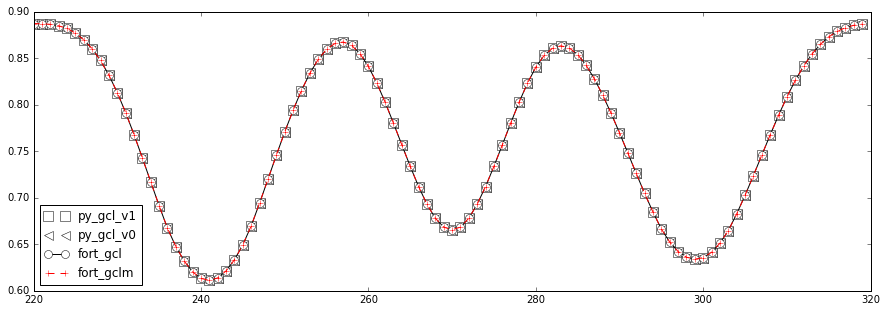

In [16]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)

plt.plot(WD,P_rat_py_v1,'sk',ms=10,mfc='w',label ='py_gcl_v1')
#plt.plot(-WD,P_rat_py_v1,'x--',label ='py_gcl_v1_inv')

plt.plot(WD,P_rat_py_v0,'<b',ms=9,mfc='w',label ='py_gcl_v0')
#plt.plot(-WD,P_rat_py_v0,'-',label ='py_gcl_v0_inv')

plt.plot(WD,P_rat_fgcl,'-ok',ms=8,mec='k',mfc='w',label ='fort_gcl')
#plt.plot(-WD,P_rat_fgcl,'+--',label ='fort_gcl')

plt.plot(WD,P_rat_fgclm,'--+r',label ='fort_gclm')
#plt.plot(-WD,P_rat_fgclm_s,'.-',label ='fort_gclm')

#plt.plot(WD,P_rat_fgclm_rdn,'o',label ='fort_gclm_s_rdn')


plt.legend(loc=3)
ax = plt.gca()

In [21]:
WS_cases=np.arange(4,26)
WD_cases=np.arange(0,360,2)
WS_ms,WD_ms=np.meshgrid(WS_cases,WD_cases)
WS=WS_ms.flatten()
WD=WD_ms.flatten()

In [22]:
out = gcl(WF=wf, WS=WS, WD=WD, TI=0.1*np.ones_like(WD), version='fort_gcl')
out.p_wt.shape

(3960, 4)

In [23]:
WS_cases=np.arange(4,26)
WD_cases=np.arange(0,360,2)
WS_ms,WD_ms=np.meshgrid(WS_cases,WD_cases)
WS=WS_ms.reshape(-1,1)*np.ones([1,wf.nWT])
WS=WS+np.random.normal(0,0.5,size=WS.shape)
WD=WD_ms.reshape(-1,1)*np.ones([1,wf.nWT])
WD=WD+np.random.normal(0,3,size=WS.shape)

In [24]:
out = gcl(WF=wf, WS=WS, WD=WD, TI=0.1*np.ones_like(WD), version='fort_gclm')
out.p_wt.shape

(3960, 4)